In [ ]:
# https://www.tensorflow.org/tutorials/generative/autoencoder
import tensorflow as tf
from tensorflow import keras

In [ ]:
# mnist = keras.datasets.fashion_mnist
# (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

X shape: (60000, 28, 28)  - type: uint8
y shape: (60000,)  - type: uint8


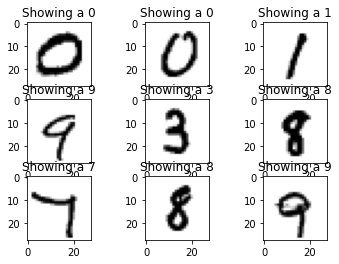

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print('X shape: ' + repr(X_train_full.shape) , ' - type: ' + str(X_train_full.dtype))
print('y shape: ' + repr(y_train_full.shape) , ' - type: ' + str(X_train_full.dtype))

tmpidxs = np.random.permutation( X_train_full.shape[0] )[:9]

plt.clf()
for i in range(9):
    plt.subplot(3,3,i+1)
    tmp_idx = tmpidxs[i]
    plt.imshow(X_train_full[tmp_idx,:,:], cmap='gray_r')
    plt.title('Showing a ' + str( y_train_full[tmp_idx] ) )
plt.show()

In [ ]:
# also readjust range to float 0-1 for gradient descend training

X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstruction(model, X, n_images=5):
    reconstruction_idxs = np.random.permutation(np.arange(X.shape[0]))[:n_images]
    reconstructions = model.predict(X[reconstruction_idxs])
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X[reconstruction_idxs[image_index]])
        plt.subplot(2, n_images, 1 + image_index + n_images)
        plot_image( reconstructions[image_index] )

In [ ]:
latent_size = 1024

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

latent = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(latent_size)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Dense(3*3*64),
    keras.layers.Reshape((3,3,64)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                 activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                 activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                 activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, latent, conv_decoder])

conv_encoder.summary()
latent.summary()
conv_decoder.summary()
conv_ae.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)        

In [ ]:
conv_ae.compile(loss='binary_crossentropy',
              optimizer='adam', # try sgd
              metrics=['cosine_similarity'])

In [ ]:
history = conv_ae.fit(X_train, X_train, validation_data=(X_train, X_train), 
                      epochs=10)

Epoch 1/10
1719/1719 [==============================] - 127s 73ms/step - loss: 0.1033 - cosine_similarity: 0.6580 - val_loss: 0.0800 - val_cosine_similarity: 0.6839
Epoch 2/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.0768 - cosine_similarity: 0.6870 - val_loss: 0.0746 - val_cosine_similarity: 0.6895
Epoch 3/10
1719/1719 [==============================] - 124s 72ms/step - loss: 0.0733 - cosine_similarity: 0.6907 - val_loss: 0.0723 - val_cosine_similarity: 0.6918
Epoch 4/10
1719/1719 [==============================] - 124s 72ms/step - loss: 0.0714 - cosine_similarity: 0.6926 - val_loss: 0.0706 - val_cosine_similarity: 0.6935
Epoch 5/10
1719/1719 [==============================] - 124s 72ms/step - loss: 0.0703 - cosine_similarity: 0.6938 - val_loss: 0.0698 - val_cosine_similarity: 0.6942
Epoch 6/10
1719/1719 [==============================] - 128s 74ms/step - loss: 0.0694 - cosine_similarity: 0.6947 - val_loss: 0.0688 - val_cosine_similarity: 0.6953
Epoch 7/10

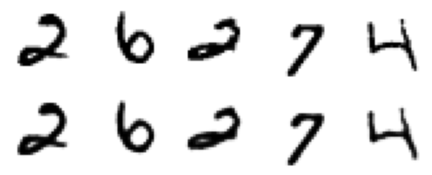

In [ ]:
show_reconstruction(conv_ae, X_valid)

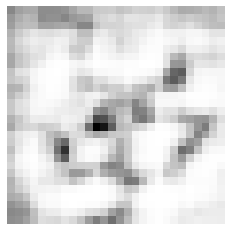

In [ ]:
# random input does not work
random_input = np.random.rand(1, latent_size)
y = conv_decoder.predict( random_input )
plot_image(y[0,:,:])

In [ ]:
# check what the latent output is for some samples
encoder_latent = keras.models.Sequential([conv_encoder, latent])

In [ ]:
y = encoder_latent.predict( X_valid[:2048, :,:] )
y.shape

(2048, 1024)

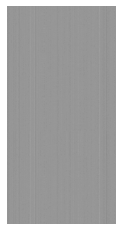

In [ ]:
plot_image(y)

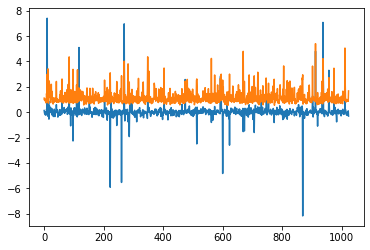

In [ ]:
plt.plot(np.mean(y, axis=0))
plt.plot(np.std(y, axis=0))

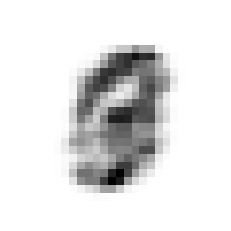

In [ ]:
# let's run the "average" input through the generative part of the network
m = np.mean( y, axis=0 )
mi = conv_decoder.predict( np.reshape( m , (1,m.size) ) )
plot_image(mi[0,:,:])

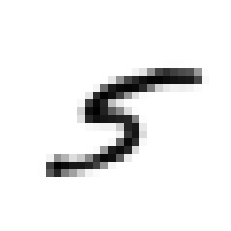

In [ ]:
# let's run one specific input through the generative part of the network
p = y[523,:]
pi = conv_decoder.predict( np.reshape( p , (1,p.size) ) )
plot_image(pi[0,:,:])

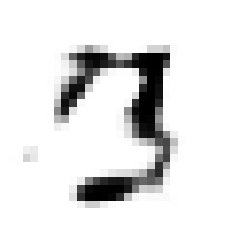

In [ ]:
# what if we sample randomly from the latent distribution, considering it normal?
c = np.cov(y.T)
n = np.random.multivariate_normal( np.mean(y, axis=0), c )
n = conv_decoder.predict( np.reshape( n , (1,n.size) ) )
plot_image(n[0,:,:])
# run it multiple times - the results are, in the best case, blurry

In [ ]:
# variational autoencoder
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2) + mean


codings_size = 10

# encoder
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

# decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.Model(
    inputs=[decoder_inputs], outputs=[outputs]
)

# %%

_, _, codings = variational_encoder( inputs )
reconstructions = variational_decoder( codings )
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
# losses

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


latent_loss = -0.5*K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss( K.mean(latent_loss)/784. )
variational_ae.compile(loss='binary_crossentropy', optimizer='adam',
                       metrics=[rounded_accuracy])

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/10
430/430 [==============================] - 8s 17ms/step - loss: 0.2219 - rounded_accuracy: 0.9051 - val_loss: 0.1797 - val_rounded_accuracy: 0.9308
Epoch 2/10
430/430 [==============================] - 7s 16ms/step - loss: 0.1718 - rounded_accuracy: 0.9355 - val_loss: 0.1646 - val_rounded_accuracy: 0.9392
Epoch 3/10
430/430 [==============================] - 7s 16ms/step - loss: 0.1618 - rounded_accuracy: 0.9414 - val_loss: 0.1579 - val_rounded_accuracy: 0.9435
Epoch 4/10
430/430 [==============================] - 7s 17ms/step - loss: 0.1564 - rounded_accuracy: 0.9446 - val_loss: 0.1536 - val_rounded_accuracy: 0.9465
Epoch 5/10
430/430 [==============================] - 7s 16ms/step - loss: 0.1530 - rounded_accuracy: 0.9468 - val_loss: 0.1505 - val_rounded_accuracy: 0.9482
Epoch 6/10
430/430 [==============================] - 7s 16ms/step - loss: 0.1507 - rounded_accuracy: 0.9483 - val_loss: 0.1491 - val_rounded_accuracy: 0.9493
Epoch 7/10
430/430 [==========================

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


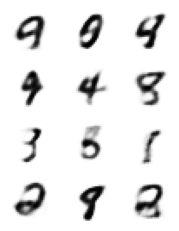

In [ ]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, n_cols=3)

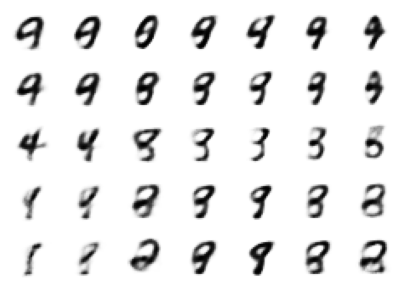

In [ ]:
codings_grid = tf.reshape(codings, [1,3,4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
plot_multiple_images(images, n_cols=7)